# Part 1: Character-Level Language Model
## Teaching a neural network to generate names

In this first part, we'll build a **character-level language model** from scratch. Given a sequence of characters, our model will learn to predict the next character. By doing this repeatedly, we can generate new text—in our case, new names.

This is the foundation of how large language models work, just at a much smaller scale.

## The Big Picture

```
Input: "nipu" → Model → Output: probability distribution over next character
                                 'n': 0.7, 'a': 0.1, 'r': 0.05, ...
```

The model learns:

1. After "nipu", 'n' is likely (forming "nipun")
2. Names often end with 'a', 'i', or consonants
3. Certain character combinations are common in names

## Setup

In [17]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

# Reproducibility
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
%config InlineBackend.figure_format = 'retina'


Using device: cpu
PyTorch version: 2.9.1


## Step 1: Get the Data

We'll use a dataset of Indian names. Let's download and explore it.

In [2]:
# Download the dataset if needed
if not os.path.exists('names.csv'):
    print("Downloading names dataset...")
    url = "https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv"
    response = requests.get(url)
    with open('names.csv', 'w') as f:
        f.write(response.text)
    print("Download complete!")

# Load and clean the data
words = pd.read_csv('names.csv')["Name"]
words = words.str.lower().str.strip().str.replace(" ", "")
words = words[words.str.len().between(3, 9)]  # Keep reasonable length names
words = words[words.apply(lambda x: x.isalpha())]  # Only alphabetic
words = words.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
words = words.tolist()

print(f"Total names: {len(words)}")
print(f"Sample names: {words[:10]}")

Download complete!
Total names: 6184
Sample names: ['subin', 'rajit', 'sheish', 'switi', 'sanaullah', 'naman', 'rahul', 'rohila', 'sehnaj', 'saad']


## Step 2: Build the Vocabulary

A vocabulary maps characters to numbers (and back). Neural networks work with numbers, not characters.

In [3]:
# Get all unique characters
chars = sorted(set(''.join(words)))
print(f"Unique characters: {''.join(chars)}")
print(f"Vocabulary size: {len(chars)}")

Unique characters: abcdefghijklmnopqrstuvwxyz
Vocabulary size: 26


In [4]:
# Create mappings
# stoi: string to integer (character → number)
# itos: integer to string (number → character)

stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0  # Special token for start/end of name

itos = {i: ch for ch, i in stoi.items()}

vocab_size = len(stoi)
print(f"Vocabulary size (including '.'): {vocab_size}")
print(f"\nCharacter to index mapping:")
print(stoi)

Vocabulary size (including '.'): 27

Character to index mapping:
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


### Why the '.' token?

The '.' is a special marker that indicates:

- **Start of name**: The model sees "....." and must predict the first character
- **End of name**: The model predicts '.' when the name is complete

This is similar to how LLMs use `<BOS>` (beginning of sequence) and `<EOS>` (end of sequence) tokens.

## Step 3: Create Training Data

We need (input, target) pairs. For a name like "raj":

| Context (input) | Target |
|-----------------|--------|
| `.....` | `r` |
| `....r` | `a` |
| `...ra` | `j` |
| `..raj` | `.` |

In [5]:
block_size = 5  # How many characters of context to use

def build_dataset(words, stoi, block_size):
    """
    Convert words into training examples.
    
    For each word, slide a window of `block_size` characters
    and predict the next character.
    """
    X, Y = [], []
    
    for word in words:
        # Start with a context of all '.' (zeros)
        context = [0] * block_size
        
        for ch in word + '.':  # Include '.' to mark end
            target = stoi[ch]
            X.append(context.copy())
            Y.append(target)
            # Slide window: remove first, add current character
            context = context[1:] + [target]
    
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(words, stoi, block_size)
print(f"Dataset size: {len(X)} examples")
print(f"Input shape: {X.shape}")  # (num_examples, block_size)
print(f"Target shape: {Y.shape}")  # (num_examples,)

Dataset size: 44325 examples
Input shape: torch.Size([44325, 5])
Target shape: torch.Size([44325])


In [6]:
# Let's visualize a few examples
print("First 10 training examples:")
print("-" * 40)
for i in range(10):
    context = ''.join(itos[idx.item()] for idx in X[i])
    target = itos[Y[i].item()]
    print(f"'{context}' → '{target}'")

First 10 training examples:
----------------------------------------
'.....' → 's'
'....s' → 'u'
'...su' → 'b'
'..sub' → 'i'
'.subi' → 'n'
'subin' → '.'
'.....' → 'r'
'....r' → 'a'
'...ra' → 'j'
'..raj' → 'i'


## Step 4: Embeddings - The First Key Idea

We can't feed characters directly to a neural network. Instead, we represent each character as a **vector of numbers** called an **embedding**.

In [7]:
# Each character becomes a vector of `emb_dim` numbers
emb_dim = 8

# PyTorch's Embedding layer is just a lookup table
embedding = nn.Embedding(vocab_size, emb_dim)

print(f"Embedding table shape: {embedding.weight.shape}")
print(f"  - {vocab_size} characters")
print(f"  - {emb_dim} dimensions each")

Embedding table shape: torch.Size([27, 8])
  - 27 characters
  - 8 dimensions each


In [8]:
# Example: embed the character 'a'
a_idx = stoi['a']
a_embedding = embedding(torch.tensor([a_idx]))
print(f"Character 'a' (index {a_idx}) → {a_embedding.squeeze().detach().numpy()}")

Character 'a' (index 1) → [-0.7521362   1.6487229  -0.39247864 -1.4036068  -0.72788125 -0.5594299
 -0.76883894  0.7624454 ]


### Why Embeddings?

1. **Learnable representations**: The network learns which characters are similar
2. **Dense vectors**: Unlike one-hot encoding (mostly zeros), embeddings are compact
3. **Capture relationships**: Similar characters (vowels, consonants) can have similar embeddings

After training, we'll see that vowels cluster together, as do similar consonants!

## Step 5: The Model Architecture

Our model has three parts:

1. **Embedding layer**: Convert characters to vectors
2. **Hidden layer**: Learn patterns in the embeddings
3. **Output layer**: Predict probability of each next character

In [9]:
class CharLM(nn.Module):
    """
    A simple character-level language model.
    
    Architecture:
        Input: [batch, block_size] integers (character indices)
          ↓
        Embedding: [batch, block_size, emb_dim]
          ↓
        Flatten: [batch, block_size * emb_dim]
          ↓
        Linear + Activation: [batch, hidden_size]
          ↓
        Linear: [batch, vocab_size] (logits)
    """
    
    def __init__(self, vocab_size, block_size, emb_dim, hidden_size):
        super().__init__()
        self.block_size = block_size
        
        # Layer 1: Embedding lookup table
        self.emb = nn.Embedding(vocab_size, emb_dim)
        
        # Layer 2: Hidden layer (learns patterns)
        self.hidden = nn.Linear(block_size * emb_dim, hidden_size)
        
        # Layer 3: Output layer (predicts next character)
        self.output = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        # x shape: [batch, block_size]
        
        # Step 1: Embed each character
        x = self.emb(x)  # [batch, block_size, emb_dim]
        
        # Step 2: Flatten the embeddings
        x = x.view(x.shape[0], -1)  # [batch, block_size * emb_dim]
        
        # Step 3: Hidden layer with activation
        x = torch.tanh(self.hidden(x))  # [batch, hidden_size]
        
        # Step 4: Output logits
        x = self.output(x)  # [batch, vocab_size]
        
        return x

In [10]:
# Create the model
hidden_size = 128
model = CharLM(vocab_size, block_size, emb_dim, hidden_size).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params:,} parameters")
print(f"\nArchitecture:")
for name, param in model.named_parameters():
    print(f"  {name}: {tuple(param.shape)}")

Model has 8,947 parameters

Architecture:
  emb.weight: (27, 8)
  hidden.weight: (128, 40)
  hidden.bias: (128,)
  output.weight: (27, 128)
  output.bias: (27,)


## Step 6: Training Loop

Training involves:

1. **Forward pass**: Compute predictions
2. **Loss calculation**: How wrong are we? (Cross-entropy loss)
3. **Backward pass**: Compute gradients
4. **Update weights**: Gradient descent

In [11]:
def train(model, X, Y, epochs=1000, batch_size=1024, lr=0.01):
    """Train the model using mini-batch gradient descent."""
    
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    # Move data to device
    X, Y = X.to(device), Y.to(device)
    
    losses = []
    
    for epoch in range(epochs):
        # Shuffle data each epoch
        perm = torch.randperm(X.shape[0])
        total_loss = 0
        n_batches = 0
        
        for i in range(0, X.shape[0], batch_size):
            # Get batch
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            
            # Forward pass
            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f}")
    
    return losses

In [12]:
# Train the model
losses = train(model, X, Y, epochs=1000, batch_size=2048, lr=0.01)

Epoch    0 | Loss: 2.5880
Epoch  200 | Loss: 1.7568
Epoch  400 | Loss: 1.7371
Epoch  600 | Loss: 1.7317
Epoch  800 | Loss: 1.7251


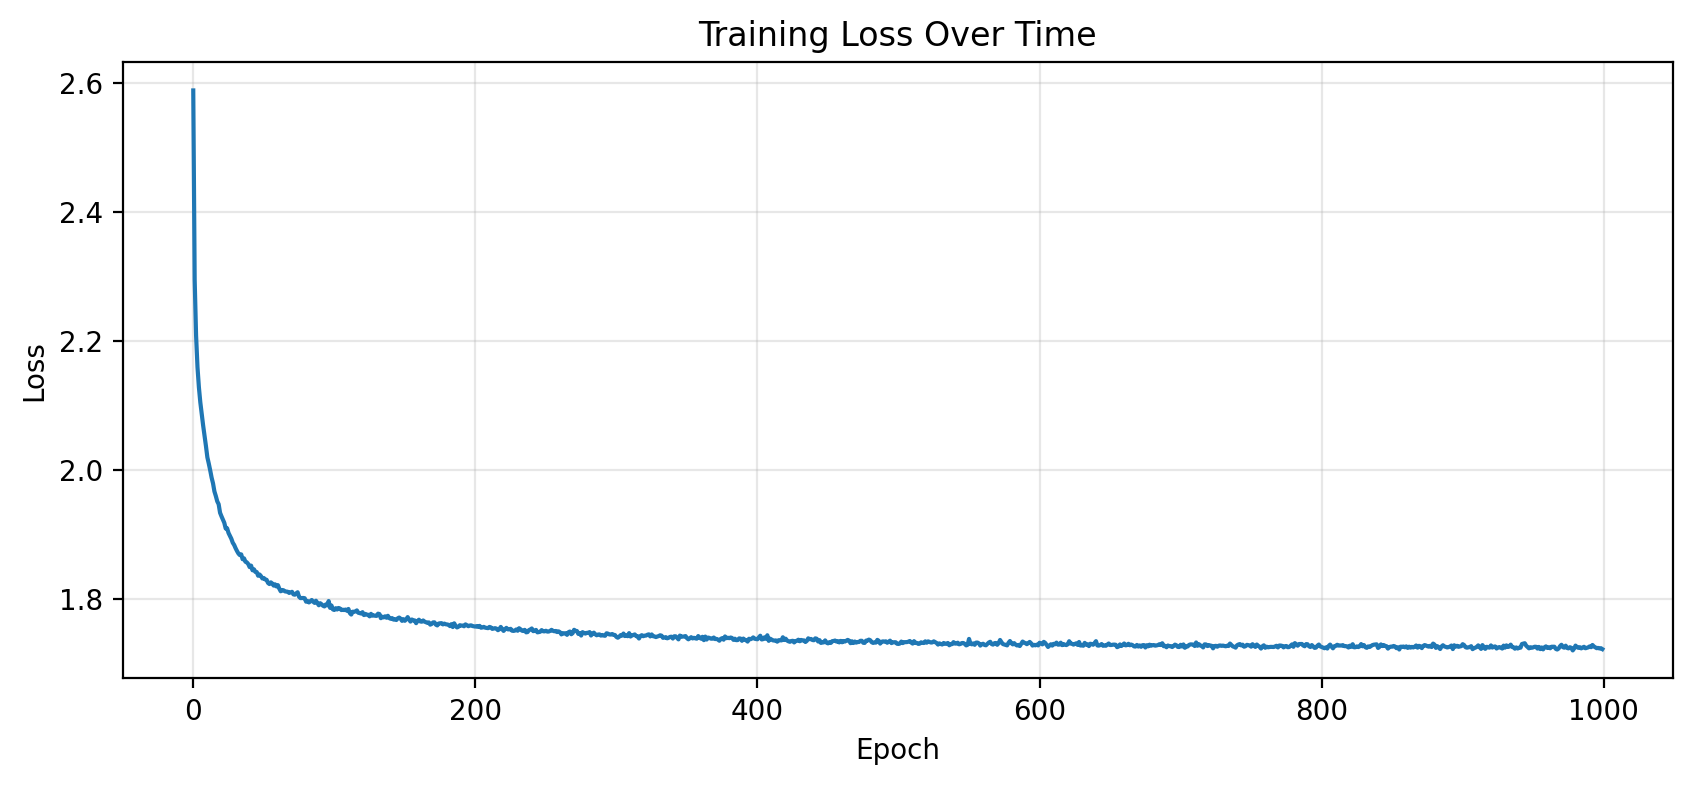

In [18]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()

### What does the loss mean?

Cross-entropy loss of ~2.0 means the model is, on average, as uncertain as if it were choosing between ~7 equally likely characters (since $e^{2.0} \approx 7.4$).

A random model would have loss $\ln(27) \approx 3.3$ (uniform over 27 characters).

## Step 7: Generate Names!

Now the fun part—let's generate new names:

In [14]:
@torch.no_grad()
def generate(model, itos, stoi, block_size, max_len=15, temperature=1.0):
    """
    Generate a name character by character.
    
    Args:
        temperature: Controls randomness (lower = more deterministic)
    """
    model.eval()
    
    context = [0] * block_size  # Start with '.....'
    name = []
    
    for _ in range(max_len):
        # Get model prediction
        x = torch.tensor([context]).to(device)
        logits = model(x)
        
        # Apply temperature
        probs = F.softmax(logits / temperature, dim=-1)
        
        # Sample from the distribution
        next_idx = torch.multinomial(probs, 1).item()
        
        # Check for end token
        if next_idx == 0:
            break
        
        name.append(itos[next_idx])
        context = context[1:] + [next_idx]
    
    return ''.join(name)

In [15]:
print("Generated Names:")
print("=" * 40)
for i in range(20):
    name = generate(model, itos, stoi, block_size, temperature=0.8)
    print(f"{i+1:2d}. {name}")

Generated Names:
 1. kamra
 2. kanti
 3. narodey
 4. silendr
 5. ritshan
 6. viksh
 7. adhishika
 8. armeel
 9. shooga
10. rambha
11. muli
12. vedey
13. nazmita
14. gulshar
15. rashid
16. sarpal
17. succip
18. ameeram
19. anjala
20. saruana


## Step 8: Visualize What the Model Learned

Let's see how the model represents characters in embedding space:

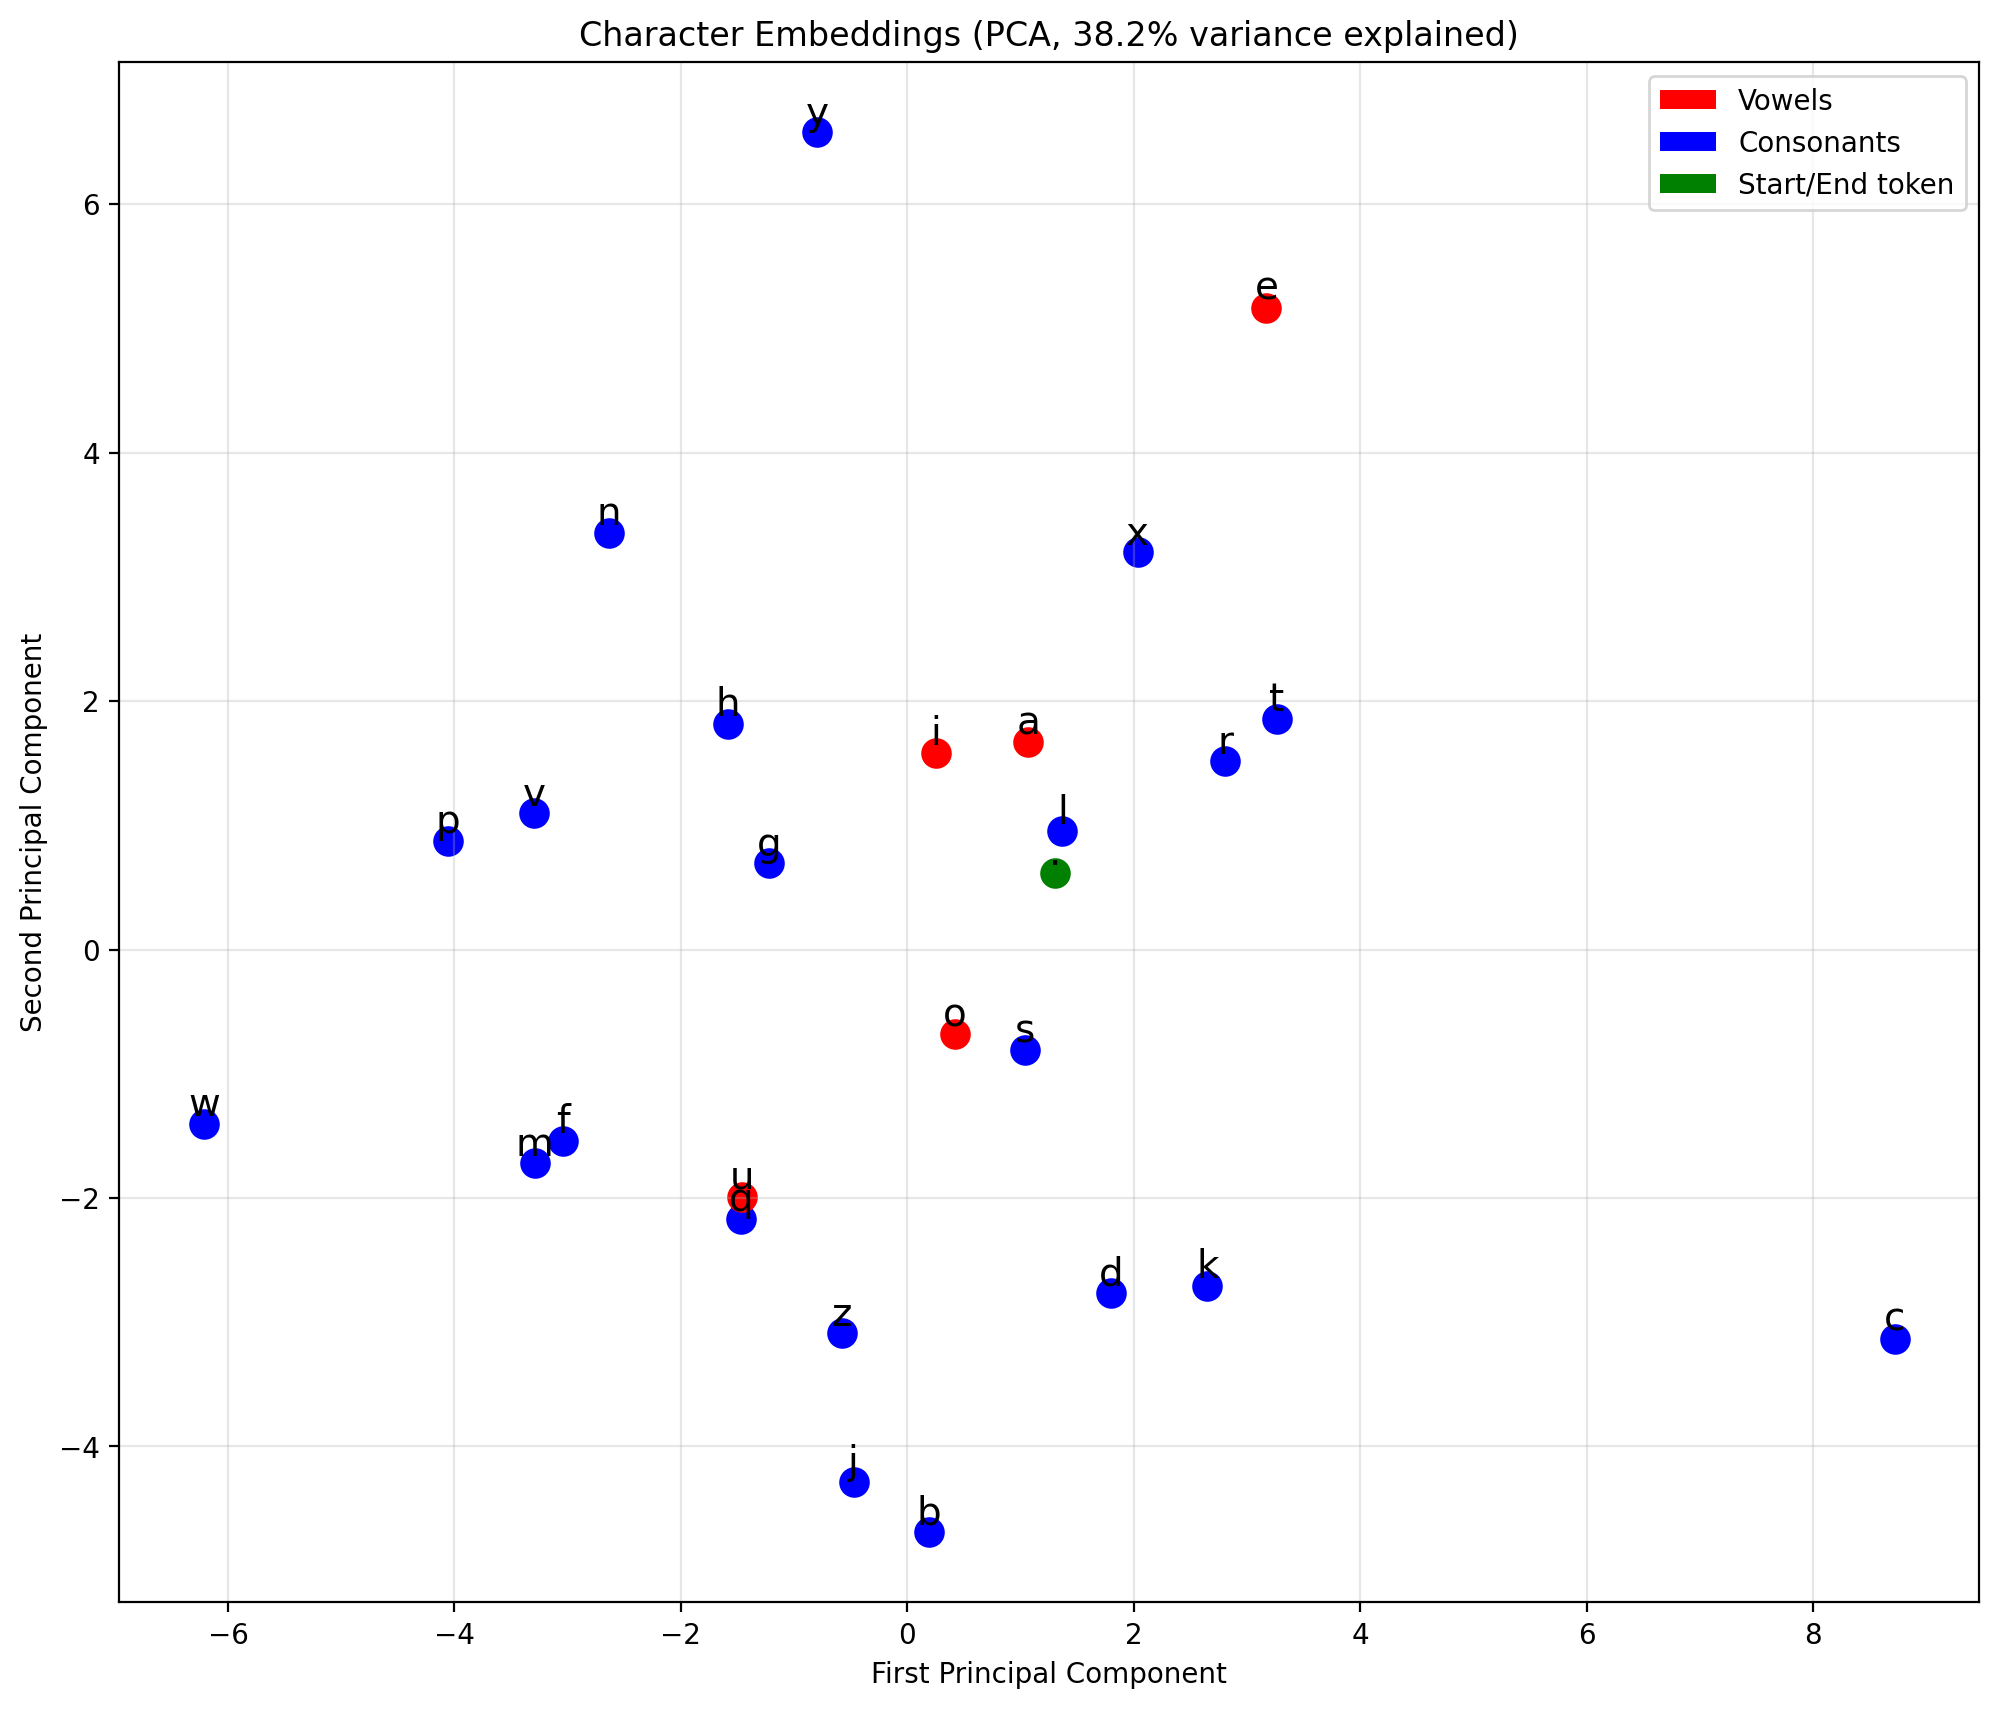

In [19]:
from sklearn.decomposition import PCA

def plot_embeddings(model, itos):
    """Visualize character embeddings using PCA."""
    weights = model.emb.weight.detach().cpu().numpy()
    
    # Reduce to 2D for visualization
    if weights.shape[1] > 2:
        pca = PCA(n_components=2)
        weights_2d = pca.fit_transform(weights)
        explained = sum(pca.explained_variance_ratio_)
    else:
        weights_2d = weights
        explained = 1.0
    
    plt.figure(figsize=(12, 10))
    
    # Color code: vowels in red, consonants in blue
    vowels = set('aeiou')
    
    for i, (x, y) in enumerate(weights_2d):
        char = itos[i]
        color = 'red' if char in vowels else ('green' if char == '.' else 'blue')
        plt.scatter(x, y, c=color, s=100)
        plt.annotate(char, (x, y), fontsize=14, ha='center', va='bottom')
    
    plt.title(f'Character Embeddings (PCA, {explained:.1%} variance explained)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Vowels'),
        Patch(facecolor='blue', label='Consonants'),
        Patch(facecolor='green', label='Start/End token')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

plot_embeddings(model, itos)

### What to look for

- **Vowels** (a, e, i, o, u) often cluster together
- **Similar consonants** may be near each other
- The **'.'** token (start/end) is usually separate

The model learned these relationships from data alone!

## Summary

In this part, we built a complete character-level language model:

| Component | Purpose |
|-----------|---------|
| Vocabulary | Map characters ↔ integers |
| Embeddings | Represent characters as learnable vectors |
| Hidden layer | Learn patterns from context |
| Output layer | Predict next character distribution |
| Training loop | Learn from data via backpropagation |
| Generation | Sample from learned distribution |

**Key parameters**:

- `block_size = 5`: Characters of context
- `emb_dim = 8`: Embedding dimensions
- `hidden_size = 128`: Hidden layer size
- Total: ~5,000 parameters

## What's Next

In **Part 2**, we'll take this same architecture and train it on Shakespeare text. Same model, different data—showing that language models are general-purpose pattern learners.

## Exercises

1. **Experiment with block_size**: What happens with 3 vs 8 characters of context?
2. **Vary hidden_size**: How does model capacity affect quality?
3. **Temperature sampling**: Try temperature 0.5 vs 1.5. What changes?
4. **Add dropout**: Implement regularization to prevent overfitting
5. **Deeper networks**: Add a second hidden layer. Does it help?